### Installing used packages

In [ ]:
# installing spacy & english small pipeline & matplotlib

# conda install -c conda-forge spacy
# python -m spacy download en_core_web_sm
# conda install conda-forge::matplotlib
# conda install anaconda::scikit-learn

### Importing used packages

In [1]:
import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

plt.style.use('seaborn-v0_8')

### Computing the vocabulary of every author

In [2]:
papers = {
    'Madison': [10, 14, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
    'Hamilton': [1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22, 23, 24,
                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 59, 60,
                 61, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
                 78, 79, 80, 81, 82, 83, 84, 85],
    'Jay': [2, 3, 4, 5],
    'Shared': [18, 19, 20],
    'Disputed': [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63],
    'TestCase': [64]
}

In [3]:
def read_files_into_string(filenames):
    strings = []
    for filename in filenames:
        with open(f'data/federalist_{filename}.txt', 'r') as f:
            strings.append(f.read())
    return '\n'.join(strings)

In [4]:
federalist_by_author = {}
for author, files in papers.items():
    federalist_by_author[author] = read_files_into_string(files)

### Initializing spaCy pipeline

In [5]:
nlp = spacy.load('en_core_web_sm')

## 1. Mendenhall Characteristic Curve (1887)
#### The method consists of comparing the count of word lengths used by each author
#### Problem: it does not take in consideration the actual words used 

In [51]:
def plot_graphs(word_lengths_hist_by_author):
    
    for author in word_lengths_hist_by_author.keys():
        
        length_counts = Counter(word_lengths_hist_by_author[author])
        word_lengths = sorted(length_counts.keys())
        counts = [length_counts[length] for length in word_lengths]
        
        plt.plot(word_lengths, counts)
        
        plt.title(f"Word length distribution for {author}")
        plt.xlabel("Length")
        plt.ylabel("Count")
        plt.show()

In [46]:
def get_word_lengths_by_author(authors_list, authors_corpus_list):
    
    word_lengths_by_author = {}
    
    for author in authors_list:
        author_doc = nlp(authors_corpus_list[author])
        # list of lengths of all the words used by an author
        author_word_lengths = [len(tok.text) for tok in author_doc if tok.is_alpha]
        
        word_lengths_by_author[author] = author_word_lengths
        
    return word_lengths_by_author
        

In [52]:
authors = ['Madison', 'Hamilton', 'Jay', 'Disputed', 'Shared']
word_lengths_hist_by_author = get_word_lengths_by_author(authors, federalist_by_author)

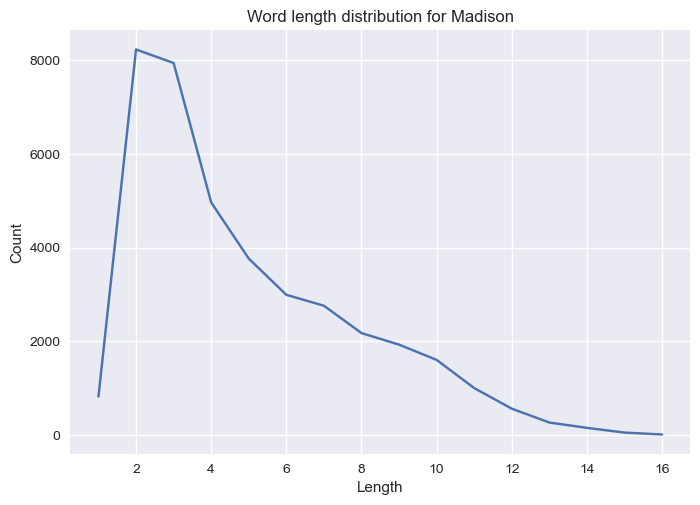

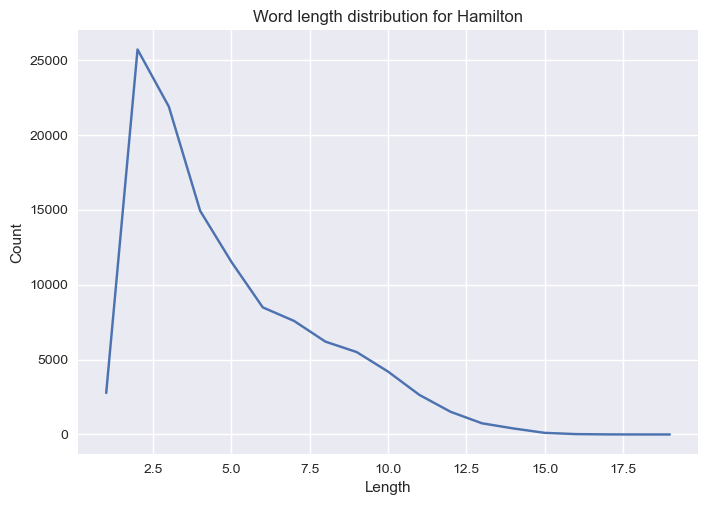

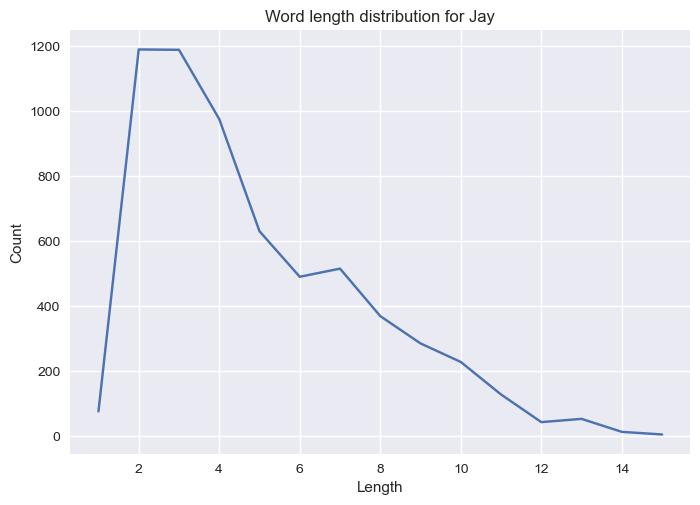

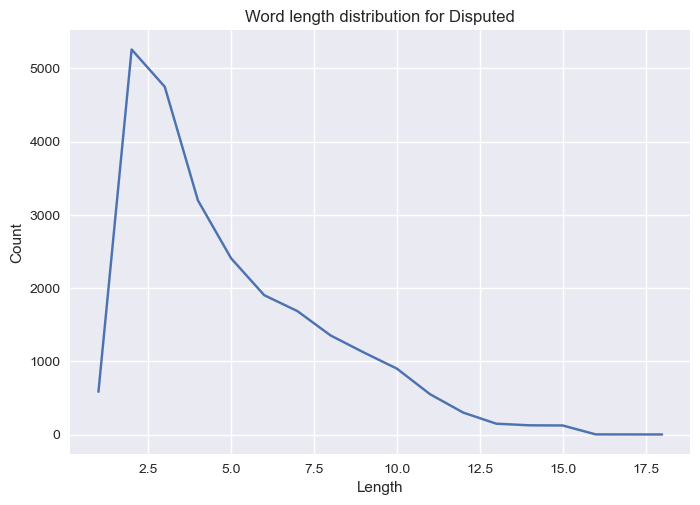

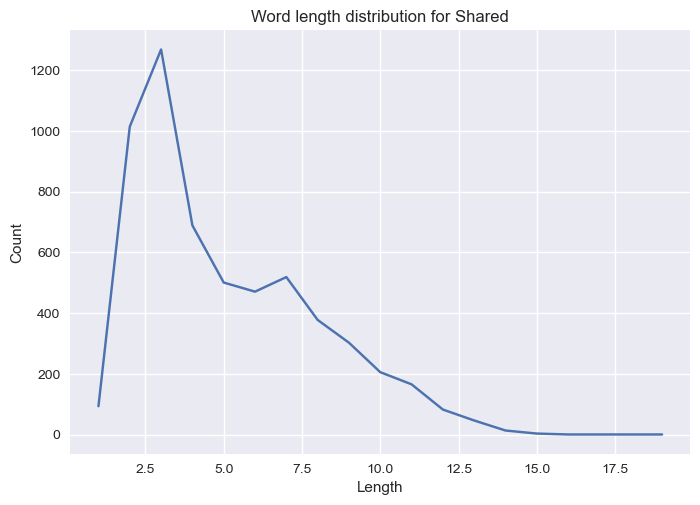

In [53]:
plot_graphs(word_lengths_hist_by_author)

#### According to Mendenhall characteristic curves, Madison, Hamilton and the disputed papers are really similar, so we can't draw and conclusions.

## 2. Kilgariff’s Chi-Squared Method (2001)
#### A method which can help us measure the distance between 2 vocabularies.

For each author:
* Concatenate the author’s vocab and the disputed vocabulary into a single list of words
* Calculate the contribution of the author to the new vocab (% represented as value between 0 and 1)
* Select the most used N words from the concatenated vocab
* For each word 'x':
    * Compute C1 and C2 (the count of appereances of word 'x' in the vocab of the writer and the disputed vocab)
    * Compute E1 and E2 (the estimated count of words if the vocabs were generated from the concatenated vocab)
    * Compute the Chi-Squared distance for both vocabs by using the formula $$\Large \frac{(C_i - E_i)^2}{E_i}$$
* Final author score is the sum of the chi-squared distances for each of the N words. (lower is closer so is better)

#### Problem 1: very used words carry a disproportionate amount of weight in the final calculation which can sometimes be wrong
#### Problem 2: we assume that one author wrote all the disputed papers (and we don't know if that's true)

In [6]:
# we make all the used words lowercase so we can count them

def get_lowercased_words_by_author(author_list, words_by_author):
    
    lowercased_author_words = {}
    
    for author in author_list:
        author_doc = nlp(words_by_author[author])
        # list of lowercased words used by an author
        author_word_lengths = [tok.text.lower() for tok in author_doc if tok.is_alpha]
        lowercased_author_words[author] = author_word_lengths
        
    return lowercased_author_words

In [7]:
authors = ['Madison', 'Hamilton', 'Jay', 'Disputed']
lowercased_author_words = get_lowercased_words_by_author(authors, federalist_by_author)

In [8]:
# N is the count of most common words to use

def chisquared_scores(analyzed_authors, lowercased_author_words, N=100):
    
    chisquared_by_author = {}
    
    for author in analyzed_authors:
        
        # author and disputed vocabs
        author_vocab = lowercased_author_words[author]
        disputed_vocab = lowercased_author_words['Disputed']
        
        # join the 2 vocabs
        joint_vocab = author_vocab + disputed_vocab
        
        # getting the most common N words in the joint vocab
        joint_vocab_words_count = Counter(joint_vocab)
        most_common_words = joint_vocab_words_count.most_common(N)
        
        # getting the % of words that come from the author in the joint
        author_contribution = len(author_vocab) / len(joint_vocab)
        
        chi_squared = 0
        
        # for every word
        for word, joint_count in most_common_words:
            
            author_word_count = lowercased_author_words[author].count(word) # C1
            disputed_word_count = lowercased_author_words["Disputed"].count(word) # C2
            
            expected_author_word_count = joint_count * author_contribution # E1
            expected_disputed_word_count = joint_count * (1 - author_contribution) # E2
            
            chi_squared += (author_word_count - expected_author_word_count) ** 2 / expected_author_word_count
            chi_squared += (disputed_word_count - expected_disputed_word_count) ** 2 / expected_disputed_word_count 
            
        chisquared_by_author[author] = chi_squared
        
    return chisquared_by_author
        
        

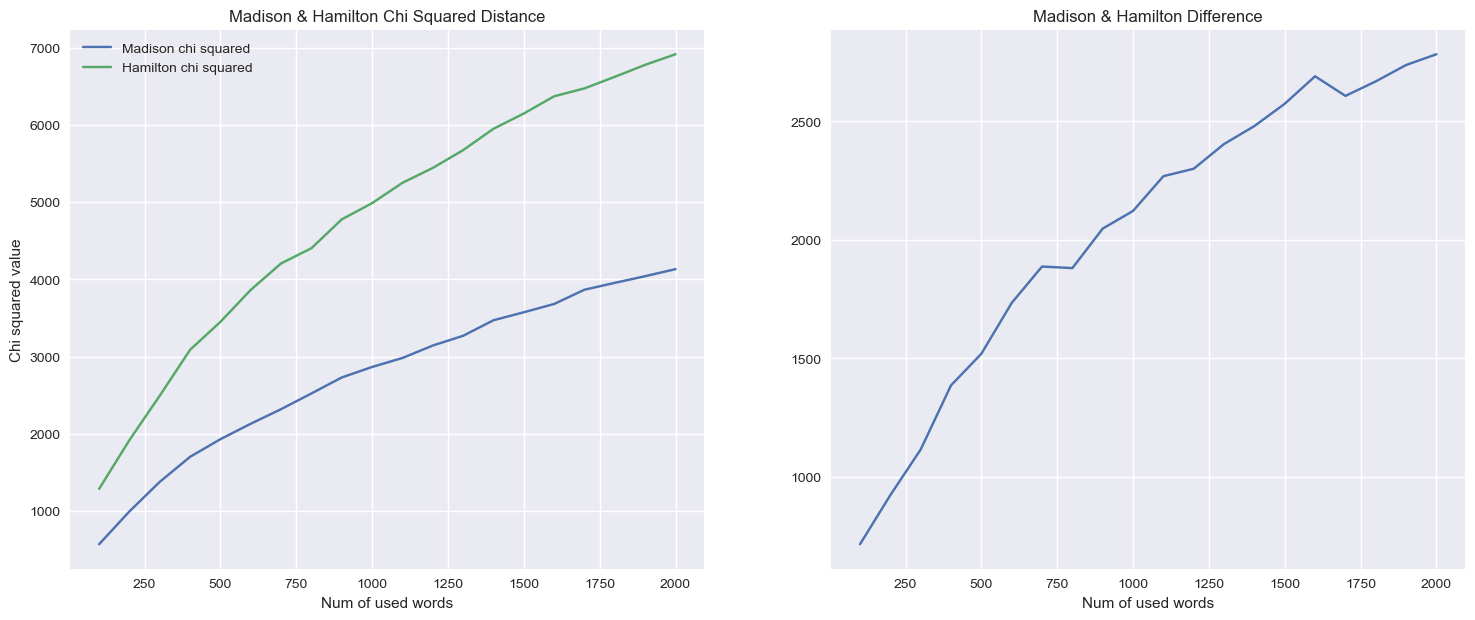

In [9]:
analyzed_authors = ['Madison', 'Hamilton']

# plotting chisquared for different Ns

madison_values = []
hamilton_values = []
X_values = []

for word_count in range(100, 2001, 100):
    
    chisquared_values = chisquared_scores(analyzed_authors, lowercased_author_words, word_count)
    madison_values.append(chisquared_values['Madison'])
    hamilton_values.append(chisquared_values['Hamilton'])
    X_values.append(word_count)

madison_values = np.asarray(madison_values)
hamilton_values = np.asarray(hamilton_values)

# plotting the chisquared values and their difference

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
ax1.plot(X_values, madison_values, label = "Madison chi squared")
ax1.plot(X_values, hamilton_values, label = "Hamilton chi squared")
ax1.set_title('Madison & Hamilton Chi Squared Distance')
ax1.set_xlabel('Num of used words')
ax1.set_ylabel('Chi squared value')

difference = np.abs(madison_values - hamilton_values)

ax2.plot(X_values, difference, label = "Difference between chi squared values of Hamilton and Madison")
ax2.set_title('Madison & Hamilton Difference')
ax2.set_xlabel('Num of used words')

ax1.legend()
plt.show()

### According to Kilgariff’s chi-squared method, Madison wrote the disputed papers.

## 3. John Burrows’ Delta Method (2002)
#### Another method that can help use measure the distance between 2 vocabularies.

We join the corpuses that have known authors. The N most common words will be used as features.
For each feature (word) we will compute how much (%) it represents from each author's vocab. 
We compute the mean and std dev for every feature.
Then for each value we compute the z-score.
Burrow's Delta for an author is the average of the absolute values of the differences between the z-scores for each feature.
$$ \huge \Delta_{author} =  \frac{\sum_i \left| Z_{author(i)} - Z_{test(i)} \right|}{N} $$



In [7]:
# we make all the used words lowercase so that we can count them

def get_lowercased_words_by_autor(author_list, words_by_author):
    
    lowercased_author_words = {}
    
    for author in author_list:
        author_doc = nlp(words_by_author[author])
        # list of lowercased words used by an author
        author_word_lengths = [tok.text.lower() for tok in author_doc if tok.is_alpha]
        lowercased_author_words[author] = author_word_lengths
        
    return lowercased_author_words

In [8]:
def get_feature_values_by_author(author_list, lowercase_words_by_author, most_common_features):
    
    feature_values_by_author = {}
    
    for author in author_list:
        
        feature_values_by_author[author] = {}
        author_word_count = len(lowercase_words_by_author[author])
        
        for feature in most_common_features:
            
            feature_count = lowercase_words_by_author[author].count(feature)
            feature_values_by_author[author][feature] = feature_count / author_word_count
        
    return feature_values_by_author
    

In [9]:
def get_mean_and_std_by_feature(author_list, features, feature_values_by_author):
    
    joint_corpus_features = {}
    
    for feature in features:
        
        values = np.zeros(len(author_list))
        
        for idx, author in enumerate(author_list):
            
            values[idx] = feature_values_by_author[author][feature]
            
        joint_corpus_features[feature] = {}
        joint_corpus_features[feature]['Mean'] = np.mean(values)
        joint_corpus_features[feature]['STD'] = np.std(values)
        
    return joint_corpus_features
            

In [10]:
def get_features_zscores_by_author(author_list, features, feature_values_by_author, mean_and_std_by_feature):
    
    feature_zscores_by_author = {}
    
    for author in author_list:
        
        feature_zscores_by_author[author] = {}
        
        for feature in features:
            
            value = feature_values_by_author[author][feature]
            mean = mean_and_std_by_feature[feature]['Mean']
            std = mean_and_std_by_feature[feature]['STD']
            
            feature_zscores_by_author[author][feature] = (value - mean) / std
            
    return feature_zscores_by_author

In [11]:
def get_test_feature_zscores(test_paper, features, mean_and_std_by_feature):
    
    doc_test_paper = nlp(test_paper)
    doc_test_lower = [tok.text.lower() for tok in doc_test_paper if tok.is_alpha]
    
    word_count_test = len(doc_test_lower)
    test_feature_zscores = {}
    
    for feature in features:
        #  the feature value is the percent of that word from the vocab so we count and divide by vocab length
        count = doc_test_lower.count(feature) 
        value = count / word_count_test
        
        mean = mean_and_std_by_feature[feature]['Mean']
        std = mean_and_std_by_feature[feature]['STD']
        
        test_feature_zscores[feature] = (value - mean) / std
        
    return test_feature_zscores

In [12]:
def compute_delta_values(author_list, features, feature_zscore_by_author, feature_zscores_test):
    
    delta_by_author = {}
    
    for author in author_list:
        
        delta = 0
        
        for feature in features:
            delta += np.abs(feature_zscores_test[feature] - feature_zscore_by_author[author][feature])
            
        delta /= len(features)
        delta_by_author[author] = delta
        
    return delta_by_author

In [13]:
authors = ['Madison', 'Hamilton', 'Jay'] 
lowercase_words_by_author = get_lowercased_words_by_autor(authors, federalist_by_author)

In [23]:
joint_vocab = lowercase_words_by_author['Madison'] + lowercase_words_by_author['Hamilton'] + lowercase_words_by_author['Jay'] 
joint_vocab_features_count = Counter(joint_vocab)
N = 10
most_common_features = [word for word, _ in joint_vocab_features_count.most_common(N)]
feature_values_by_author = get_feature_values_by_author(authors, lowercase_words_by_author, most_common_features)
mean_and_std_by_feature = get_mean_and_std_by_feature(authors, most_common_features, feature_values_by_author)
feature_zscore_by_author = get_features_zscores_by_author(authors, most_common_features, feature_values_by_author, mean_and_std_by_feature)

In [24]:
# testing for each disputed paper

for num in papers['Disputed']:
    f = open(f'data/federalist_{num}.txt', 'r')
    test_words = f.read()
    
    test_feature_zscores = get_test_feature_zscores(test_words, most_common_features, mean_and_std_by_feature)
    delta_by_author = compute_delta_values(authors, most_common_features, feature_zscore_by_author, test_feature_zscores)
    print(f'Paper {num}: {delta_by_author}')

Paper 49: {'Madison': 1.0922840535418348, 'Hamilton': 1.3311786418628806, 'Jay': 2.396867616921754}
Paper 50: {'Madison': 1.7684371010307351, 'Hamilton': 1.9185075103624178, 'Jay': 2.387687809654176}
Paper 51: {'Madison': 1.7883750211674152, 'Hamilton': 1.8308707527121455, 'Jay': 3.0107946475461818}
Paper 52: {'Madison': 1.2821740078768402, 'Hamilton': 1.178516398272342, 'Jay': 1.7027289152292646}
Paper 53: {'Madison': 0.9028360658845447, 'Hamilton': 1.3108520116262365, 'Jay': 2.479852346277371}
Paper 54: {'Madison': 0.9049569975249959, 'Hamilton': 1.1500398992167047, 'Jay': 2.4680771890413036}
Paper 55: {'Madison': 1.3072504785541628, 'Hamilton': 1.1870927879827686, 'Jay': 2.4367877603548935}
Paper 56: {'Madison': 1.3375232968895887, 'Hamilton': 1.6757970479819562, 'Jay': 2.4227176592920303}
Paper 57: {'Madison': 0.5138849609547428, 'Hamilton': 1.0170888134022085, 'Jay': 1.8861107796229848}
Paper 58: {'Madison': 1.3436044483667415, 'Hamilton': 1.2724333752274457, 'Jay': 2.338000182668

### According to John Burrows’ delta method:
### Madison probably wrote 9 of the disputed papers (49, 50, 51, 53, 54, 56, 57, 62, 63).
### Hamilton probably wrote 3 of the papers (52, 55, 58)

## 4. Clustering
#### We will use agglomerative clustering with a Ward linkage and plot the dendogram.
#### The feature vector will be the frequencies of different functional words found on page 25 of the article [here](https://ptrckprry.com/course/ssd/reading/Most63.pdf).

In [11]:
# this time a paper will be its own string

def read_files_into_strings(filenames):
    strings = []
    for filename in filenames:
        with open(f'data/federalist_{filename}.txt', 'r') as f:
            strings.append(f.read())
    return strings

In [21]:
federalist_by_author = {}
for author, files in papers.items():
    federalist_by_author[author] = read_files_into_strings(files)

In [22]:
author2spacy = {}

for author, author_papers in federalist_by_author.items():
    author2spacy[author] = []
    for document in nlp.pipe(author_papers, batch_size=10):
        author2spacy[author].append(document)
        

In [25]:
article_functional_words = ['according', 'also', 'although', 'always', 'an', 'apt', 'both', 'by', 'commonly',
                       'consequently', 'considerable', 'considerably', 'direction', 'enough', 'innovation',
                       'innovations', 'kind', 'language', 'matter', 'matters', 'of', 'on', 'particularly',
                       'probability', 'there', 'this', 'though', 'to', 'upon', 'vigor', 'vigorous', 'while',
                       'whilst', 'work', 'works']

In [27]:
# function to count the num of functional words in a document and normalize them

def count_words_in_doc(document, words):
    
    cnt_words = 0
    
    functional_words_count = {x:0 for x in words}
    
    for tok in document:
        if tok.is_alpha:
           cnt_words += 1
           if tok.text.lower() in words:
               functional_words_count[tok.text.lower()] += 1
               
    feature_vector = np.zeros(len(words))
    
    for idx, word in enumerate(words):
        
        feature_vector[idx] = functional_words_count[word]
        
    return feature_vector / cnt_words
            

In [28]:
X = []
labels = []

for author in ["Madison", "Hamilton", "Disputed", "Jay", "TestCase"]:
    for document in author2spacy[author]:
        X.append(count_words_in_doc(document, article_functional_words))
        labels.append(author)

X = np.array(X)

In [30]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [32]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(X)


AgglomerativeClustering(distance_threshold=0, n_clusters=None)

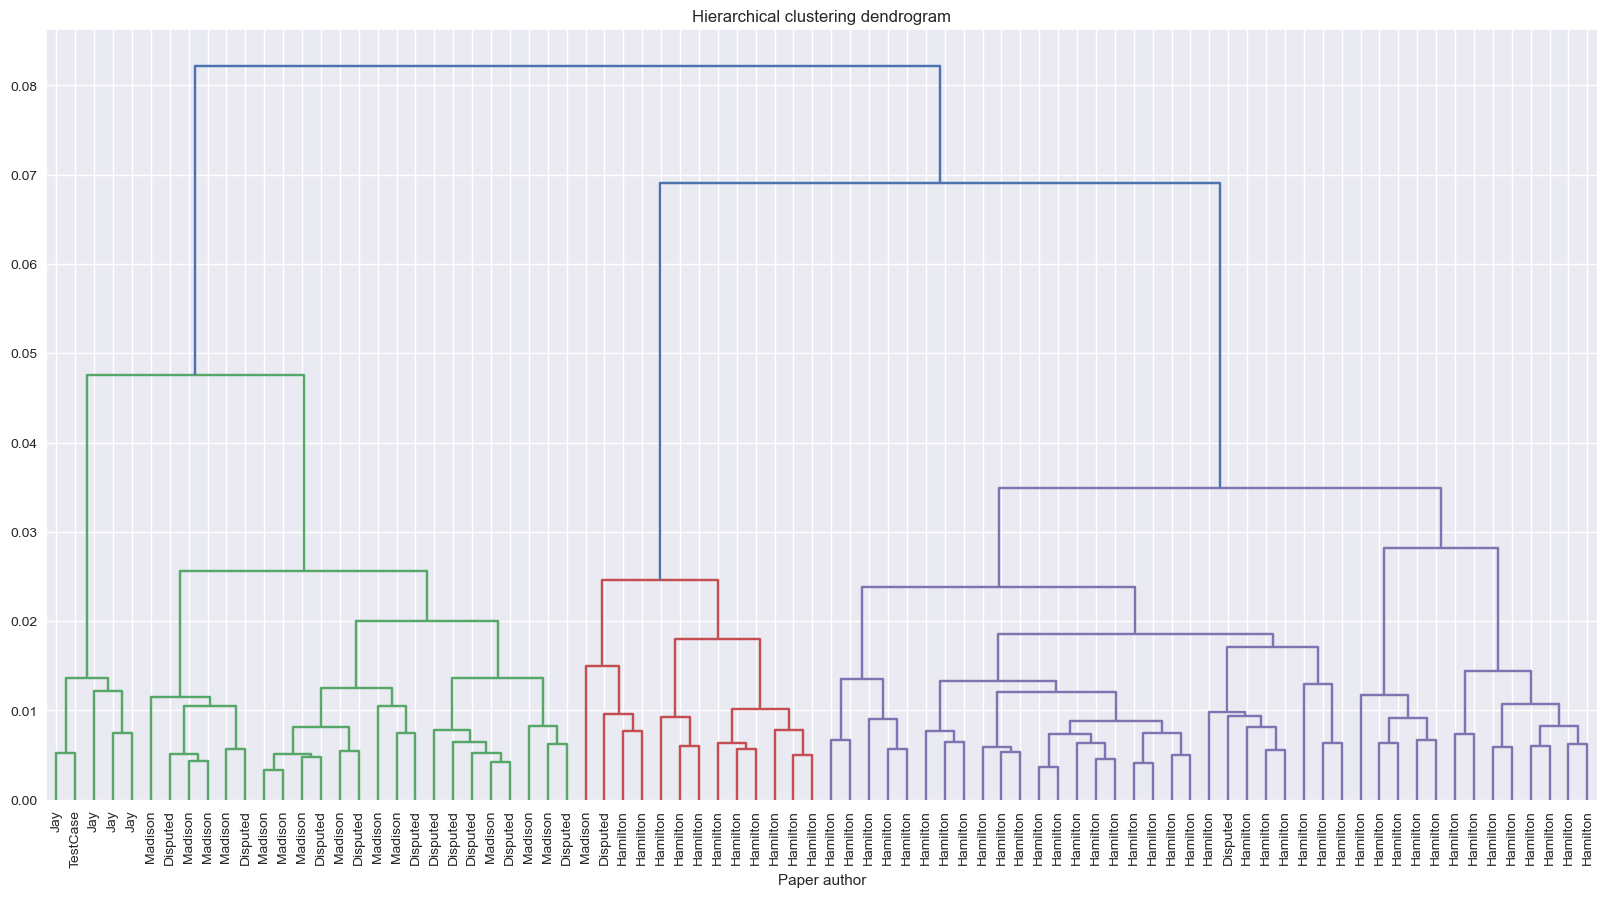

In [35]:
plt.figure(figsize=(20, 10))
plot_dendrogram(model, labels=labels, leaf_rotation=90, leaf_font_size=10)
plt.xlabel("Paper author")
plt.title('Hierarchical clustering dendrogram')
plt.show()

### By hierarchical clustering by the frequencies of the functional words, we can say that 10 of the 12 papers were written by Madison and 2 of them by Hamilton.